# 1. Import and Install Dependencies

## 1.1 Install Dependencies

In [ ]:
 ! pip install tensorflow tensorflow_io matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## 1.2 Load Dependencies

In [ ]:
import os
from matplotlib import pyplot as plt
import tensorflow as tf
import tensorflow_io as tfio
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
physical_devices = tf.config.list_physical_devices('GPU')
print("Num GPUs:", len(physical_devices))

Num GPUs: 1


In [ ]:
! python --version

Python 3.10.12


In [ ]:
print(tfio.__version__, tf.__version__)

0.32.0 2.12.0


# 2. Build Data Loading Function

## 2.1 Define Paths to Files

In [ ]:
capuchin_file = os.path.join('/content/gdrive/MyDrive/Machine Learning/Deep Audio Classifier/data', 'Parsed_Capuchinbird_Clips','XC3776-3.wav')
not_capuchin_file = os.path.join('/content/gdrive/MyDrive/Machine Learning/Deep Audio Classifier/data', 'Parsed_Not_Capuchinbird_Clips', 'afternoon-birds-song-in-forest-0.wav')

## 2.2 Build Dataloading Function

In [ ]:
def load_wav_16k_mono(filename):
    #Load encoded wav file
    file_contents = tf.io.read_file(filename)
    #Decode wav (tensors by channels)
    wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)
    #Removes trailing axis
    wav = tf.squeeze(wav, axis=1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    #Goes from 44100Hz to 16000Hz - amplitude of the audio signal
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
    return wav

## 2.3 Plot Wave

In [ ]:
wave = load_wav_16k_mono(capuchin_file)
nwave = load_wav_16k_mono(not_capuchin_file)

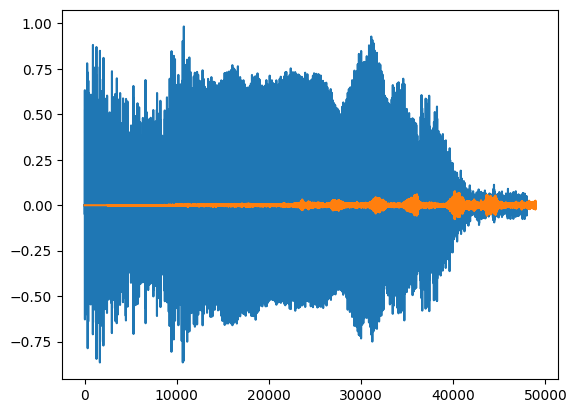

In [ ]:
plt.plot(wave)
plt.plot(nwave)
plt.show()

# 3. Create Tensorflow Dataset

## 3.1 Define Paths to Positive and Negative Data

In [ ]:
POS = os.path.join('/content/gdrive/MyDrive/Machine Learning/Deep Audio Classifier/data','Parsed_Capuchinbird_Clips')
NEG = os.path.join('/content/gdrive/MyDrive/Machine Learning/Deep Audio Classifier/data','Parsed_Not_Capuchinbird_Clips')

## 3.2 Create Tensorflow Datasets

In [ ]:
pos = tf.data.Dataset.list_files(POS+'/*.wav')
neg = tf.data.Dataset.list_files(NEG+'/*.wav')

In [ ]:
pos.as_numpy_iterator().next()

b'/content/gdrive/MyDrive/Machine Learning/Deep Audio Classifier/data/Parsed_Capuchinbird_Clips/XC307385-4.wav'

## 3.3 Add Labels and Combine Positive and Negative Samples

In [ ]:
positives = tf.data.Dataset.zip((pos, tf.data.Dataset.from_tensor_slices(tf.ones(len(pos)))))
negatives = tf.data.Dataset.zip((neg, tf.data.Dataset.from_tensor_slices(tf.zeros(len(pos)))))
data = positives.concatenate(negatives)

In [ ]:
len(data)

434

In [ ]:
data.shuffle(1000).as_numpy_iterator().next()

(b'/content/gdrive/MyDrive/Machine Learning/Deep Audio Classifier/data/Parsed_Not_Capuchinbird_Clips/screech-owl-sounds-at-night-1.wav',
 0.0)

# 4. Determine Average Length of a Capuchin Call

## 4.1 Calculate Wave Cycle Length

In [ ]:
lengths = []
for file in os.listdir(os.path.join('/content/gdrive/MyDrive/Machine Learning/Deep Audio Classifier/data','Parsed_Capuchinbird_Clips')):
    tensor_wave = load_wav_16k_mono(os.path.join('/content/gdrive/MyDrive/Machine Learning/Deep Audio Classifier/data','Parsed_Capuchinbird_Clips',file))
    lengths.append(len(tensor_wave))

## 4.2 Calculate Min, Max, Mean

In [ ]:
tf.math.reduce_mean(lengths).numpy(), tf.math.reduce_max(lengths).numpy(), tf.math.reduce_min(lengths).numpy()

(54156, 80000, 32000)

# 5. Build PreProcessing Function to Convert to Spectrogram

#5.1 Build PreProcessing Function

In [ ]:
def preprocess(file_path, label):
    wav = load_wav_16k_mono(file_path)
    wav = wav[:48000] #we took the average length as 48000
    zero_padding = tf.zeros([48000] - tf.shape(wav), dtype=tf.float32)
    wav = tf.concat([zero_padding, wav],0)
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram, label

In [ ]:
wav = load_wav_16k_mono(capuchin_file)
wav

<tf.Tensor: shape=(48000,), dtype=float32, numpy=
array([ 8.9910554e-07, -2.7947258e-06,  7.0741157e-06, ...,
       -1.0823049e-02, -3.5766482e-03,  1.5143131e-02], dtype=float32)>

## 5.2 Test Out the Function and Viz the Spectrogram

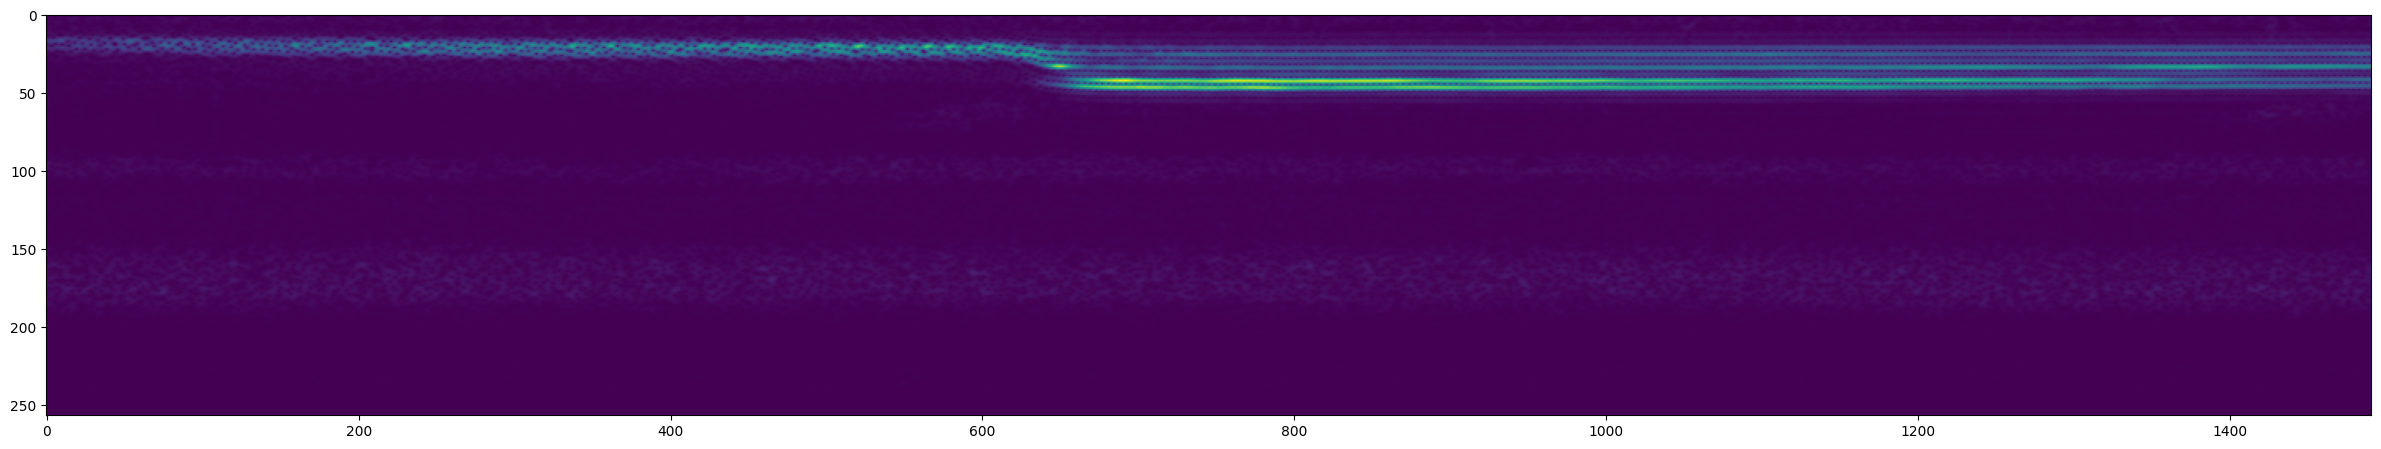

In [ ]:
filepath, label = positives.shuffle(buffer_size=10000).as_numpy_iterator().next()
# filepath, label = negatives.shuffle(buffer_size=10000).as_numpy_iterator().next()
spectrogram, label = preprocess(filepath, label)
plt.figure(figsize=(30,20))
plt.imshow(tf.transpose(spectrogram)[0])
plt.show()

# 6. Create Training and Testing Partitions

## 6.1 Create a Tensorflow Data Pipeline

In [ ]:
#MCSHBAP
data = data.map(preprocess)
data = data.cache()
data = data.shuffle(buffer_size=1000)
data = data.batch(16)
data = data.prefetch(8)

## 6.2 Split into Traninig and Testing Partitions

In [ ]:
len(data)

28

In [ ]:
train = data.take(19)
test = data.skip(19).take(9)

## 6.3 Test One Batch

In [ ]:
samples, labels = train.as_numpy_iterator().next()

In [ ]:
samples.shape

(16, 1491, 257, 1)

# 7. Build Deep Learning Model

## 7.1 Load Tensorflow Dependencies

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten

## 7.2 Build Sequential Model, Compile and View Summary

In [ ]:
model = Sequential()
model.add(Conv2D(8, (3,3), activation='relu', input_shape=(1491,257,1)))
model.add(Conv2D(8, (3,3), activation='relu'))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [ ]:
model.compile('Adam', loss='BinaryCrossentropy', metrics=[tf.keras.metrics.Recall(), tf.keras.metrics.Precision()])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 1489, 255, 8)      80        
                                                                 
 conv2d_1 (Conv2D)           (None, 1487, 253, 8)      584       
                                                                 
 flatten (Flatten)           (None, 3009688)           0         
                                                                 
 dense (Dense)               (None, 128)               385240192 
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 385,240,985
Trainable params: 385,240,985
Non-trainable params: 0
_________________________________________________________________


## 7.3 Fit Model, View Loss and KPI Plots

In [ ]:
hist = model.fit(train, epochs=20, validation_data=test)

Epoch 1/20
19/19 [==============================] - 13s 287ms/step - loss: 16.1537 - recall: 0.9408 - precision: 0.7989 - val_loss: 4.4249 - val_recall: 0.9508 - val_precision: 0.8657
Epoch 2/20
19/19 [==============================] - 4s 195ms/step - loss: 2.3326 - recall: 0.9733 - precision: 0.9419 - val_loss: 1.2515 - val_recall: 0.9531 - val_precision: 1.0000
Epoch 3/20
19/19 [==============================] - 3s 182ms/step - loss: 0.1826 - recall: 0.9864 - precision: 0.9932 - val_loss: 0.7221 - val_recall: 0.9851 - val_precision: 0.9706
Epoch 4/20
19/19 [==============================] - 3s 181ms/step - loss: 0.7013 - recall: 1.0000 - precision: 0.9933 - val_loss: 1.3086e-04 - val_recall: 1.0000 - val_precision: 1.0000
Epoch 5/20
19/19 [==============================] - 3s 175ms/step - loss: 0.0211 - recall: 0.9936 - precision: 1.0000 - val_loss: 0.0013 - val_recall: 1.0000 - val_precision: 1.0000
Epoch 6/20
19/19 [==============================] - 3s 173ms/step - loss: 0.2055 - r

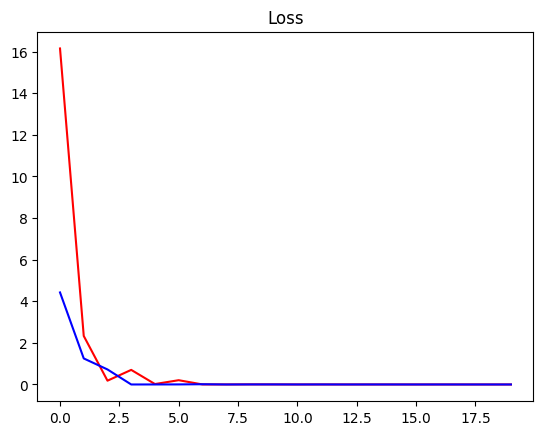

In [ ]:
plt.title('Loss')
plt.plot(hist.history['loss'],'r')
plt.plot(hist.history['val_loss'],'b')
plt.show()

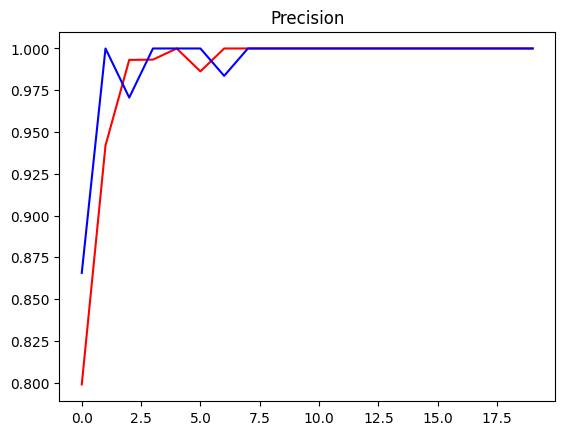

In [ ]:
plt.title('Precision')
plt.plot(hist.history['precision'],'r')
plt.plot(hist.history['val_precision'],'b')
plt.show()

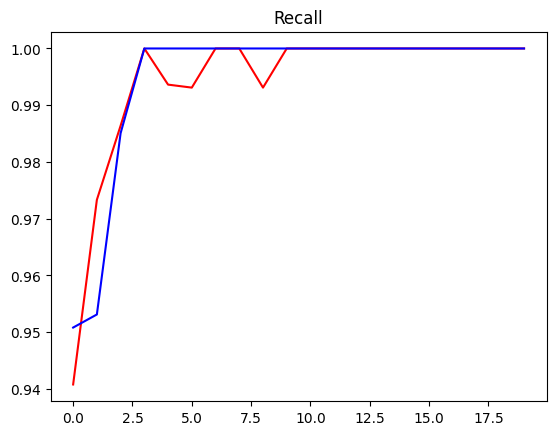

In [ ]:
plt.title('Recall')
plt.plot(hist.history['recall'],'r')
plt.plot(hist.history['val_recall'],'b')
plt.show()

# 8. Make a Prediction on a Single Clip

## 8.1 Get One Batch and Make a Prediction

In [ ]:
x_test, y_test = test.as_numpy_iterator().next()

In [ ]:
yhat = model.predict(x_test)

1/1 [==============================] - 0s 114ms/step


## 8.2 Convert Logits to Classes

In [ ]:
yhat = [1 if prediction > 0.5 else 0 for prediction in yhat]

In [ ]:
tf.math.reduce_sum(yhat).numpy(), int(tf.math.reduce_sum(y_test).numpy())

(10, 10)

# 9. Build Forest Parsing Functions

## 9.1 Load up MP3s

In [ ]:
def load_mp3_16k_mono(filename):
    """ Load a WAV file, convert it to a float tensor, resample to 16 kHz single-channel"""
    res = tfio.audio.AudioIOTensor(filename)
    # Convert to tensor and combine channels
    tensor = res.to_tensor()
    tensor = tf.math.reduce_sum(tensor, axis=1)/2
    # Extract sample rate and cast
    sample_rate = res.rate
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    # Resample to 16 kHz
    wav = tfio.audio.resample(tensor, rate_in=sample_rate, rate_out=16000)
    return wav

In [ ]:
mp3 = os.path.join('/content/gdrive/MyDrive/Machine Learning/Deep Audio Classifier/data/Forest Recordings','recording_00.mp3')

In [ ]:
wav = load_mp3_16k_mono(mp3)

In [ ]:
audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=48000, sequence_stride=48000, batch_size=1)

In [ ]:
samples, index = audio_slices.as_numpy_iterator().next()

In [ ]:
samples.shape

(1, 48000)

In [ ]:
len(audio_slices)

60

## 9.2 Build Function to Convert Clips into Windowed Spectrograms

In [ ]:
def preprocess_mp3(sample, index):
    sample = sample[0]
    zero_padding = tf.zeros([48000]-tf.shape(sample), dtype=tf.float32)
    wav = tf.concat([zero_padding, sample],0)
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram

## 9.3 Convert Longer Clips into Windows and Make Predictions

In [ ]:
audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=48000, sequence_stride=48000, batch_size=1)
audio_slices = audio_slices.map(preprocess_mp3)
audio_slices = audio_slices.batch(64)

In [ ]:
yhat = model.predict(audio_slices)
yhat = [1 if prediction > 0.99 else 0 for prediction in yhat]

1/1 [==============================] - 3s 3s/step


## 9.4 Group Consecutive Detection

In [ ]:
from itertools import groupby

In [ ]:
yhat = [key for key, group in groupby(yhat)]
calls = tf.math.reduce_sum(yhat).numpy()

In [ ]:
calls

5

# 10. Make Predictions

## 10.1 Loop Over All Recordings and Make Predictions

In [ ]:
results = {}
for file in os.listdir(os.path.join('/content/gdrive/MyDrive/Machine Learning/Deep Audio Classifier/data', 'Forest Recordings')):
    FILEPATH = os.path.join('/content/gdrive/MyDrive/Machine Learning/Deep Audio Classifier/data','Forest Recordings', file)

    wav = load_mp3_16k_mono(FILEPATH)
    audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=48000, sequence_stride=48000, batch_size=1)
    audio_slices = audio_slices.map(preprocess_mp3)
    audio_slices = audio_slices.batch(64)

    yhat = model.predict(audio_slices)

    results[file] = yhat
results

1/1 [==============================] - 1s 1s/step


{'recording_00.mp3': array([[4.23544012e-11],
        [4.52422155e-22],
        [9.72036247e-08],
        [1.00000000e+00],
        [1.00000000e+00],
        [1.96129685e-17],
        [1.33562750e-24],
        [7.55719704e-20],
        [1.11336965e-23],
        [8.57069515e-13],
        [1.04644386e-17],
        [5.63566320e-22],
        [9.48597479e-20],
        [1.00000000e+00],
        [1.00000000e+00],
        [1.71683301e-23],
        [0.00000000e+00],
        [5.66996742e-23],
        [5.66160464e-15],
        [2.39192807e-17],
        [1.01925551e-17],
        [5.74345723e-24],
        [7.87399894e-19],
        [1.00000000e+00],
        [1.00000000e+00],
        [4.33551566e-34],
        [6.12024440e-33],
        [2.82809914e-10],
        [7.24177805e-21],
        [1.28346556e-10],
        [3.10110609e-24],
        [3.39918328e-12],
        [3.05251701e-12],
        [1.20969487e-16],
        [9.30218749e-11],
        [7.20834214e-06],
        [1.00000000e+00],
        [3.5500613

## 10.2 Convert Predictions into Classes

In [ ]:
class_preds = {}
for file, logits in results.items():
    class_preds[file] = [1 if prediction > 0.99 else 0 for prediction in logits]
class_preds

{'recording_00.mp3': [0,
  0,
  0,
  1,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'recording_01.mp3': [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'recording_02.mp3': [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'recording_03.mp3': [0,
  0,
  0,
  

## 10.3 Group Consecutive Detections

In [ ]:
postprocessed = {}
for file, scores in class_preds.items():
    postprocessed[file] = tf.math.reduce_sum([key for key, group in groupby(scores)]).numpy()
postprocessed

{'recording_00.mp3': 5,
 'recording_01.mp3': 0,
 'recording_02.mp3': 0,
 'recording_03.mp3': 0,
 'recording_04.mp3': 12,
 'recording_05.mp3': 0,
 'recording_06.mp3': 14,
 'recording_07.mp3': 2,
 'recording_08.mp3': 20,
 'recording_09.mp3': 0,
 'recording_10.mp3': 6,
 'recording_11.mp3': 14,
 'recording_12.mp3': 0,
 'recording_13.mp3': 0,
 'recording_14.mp3': 0,
 'recording_15.mp3': 2,
 'recording_16.mp3': 11,
 'recording_17.mp3': 8,
 'recording_19.mp3': 1,
 'recording_18.mp3': 2,
 'recording_20.mp3': 0,
 'recording_21.mp3': 1,
 'recording_22.mp3': 2,
 'recording_23.mp3': 11,
 'recording_27.mp3': 0,
 'recording_26.mp3': 2,
 'recording_25.mp3': 12,
 'recording_24.mp3': 0,
 'recording_28.mp3': 13,
 'recording_29.mp3': 0,
 'recording_31.mp3': 1,
 'recording_30.mp3': 1,
 'recording_32.mp3': 2,
 'recording_34.mp3': 4,
 'recording_33.mp3': 0,
 'recording_35.mp3': 0,
 'recording_37.mp3': 11,
 'recording_36.mp3': 0,
 'recording_38.mp3': 7,
 'recording_41.mp3': 0,
 'recording_39.mp3': 8,
 'recor

# 11. Export Results

In [ ]:
import csv

In [ ]:
with open('/content/gdrive/MyDrive/Machine Learning/Deep Audio Classifier/results.csv', 'w', newline='') as f:
    writer = csv.writer(f, delimiter=',')
    writer.writerow(['recording', 'capuchin_calls'])
    for key, value in postprocessed.items():
        writer.writerow([key, value])